In [ ]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Step 1: Generate Random Sample Data
np.random.seed(42)
n_samples = 100

data = pd.DataFrame({
    'T90': np.random.uniform(0.1, 300, n_samples),  # Random durations
    'Fluence': np.random.uniform(1e-8, 1e-5, n_samples),  # Random fluences
    'PeakFlux': np.random.uniform(1e-9, 1e-4, n_samples),  # Random peak fluxes
    'NH': np.random.uniform(19.5, 21.5, n_samples),  # Column density
    'Fa': np.random.uniform(0.1, 10, n_samples),  # Arbitrary variable
    'Ta': np.random.uniform(1, 50, n_samples),  # Arbitrary variable
    'PhotonIndex': np.random.uniform(-1, 3, n_samples),  # Photon index
    'α': np.random.uniform(1, 4, n_samples),  # Alpha parameter
    'β': np.random.uniform(1, 4, n_samples),  # Beta parameter
    'Γ': np.random.uniform(1, 4, n_samples),  # Gamma parameter
    'z': np.random.uniform(0, 10, n_samples),  # Redshift
})

# Add random error bars for illustrative purposes
data['T90_err'] = data['T90'] * 0.1
data['Fluence_err'] = data['Fluence'] * 0.1
data['PeakFlux_err'] = data['PeakFlux'] * 0.1
data['NH_err'] = data['NH'] * 0.05

# Step 2: Transform Variables to Log-Scale
variables_to_log = ['T90', 'Fluence', 'PeakFlux', 'NH', 'Fa', 'Ta']
for var in variables_to_log:
    data[f'log_{var}'] = np.log10(data[var])

# Step 3: Assign NA Based on Thresholds
data.loc[data['log_NH'] < np.log10(20), ['NH', 'log_NH']] = np.nan
data.loc[data['PhotonIndex'] < 0, ['PhotonIndex']] = np.nan
data.loc[data['PeakFlux'] == 0, ['PeakFlux', 'log_PeakFlux']] = np.nan
data.loc[data['α'] > 3, ['α']] = np.nan
data.loc[data['β'] > 3, ['β']] = np.nan
data.loc[data['Γ'] > 3, ['Γ']] = np.nan

# Step 4: Introduce Extra Variable log(z + 1)
data['log_z+1'] = np.log10(data['z'] + 1)

# Drop rows where all values are NaN
data.dropna(how="all", inplace=True)

# Step 5: Handle Missing Data with MICE
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Display Final Data
print("Final Dataset (with Imputed Values):")
print(imputed_data.head())

# Save the Dataset for Further Analysis
imputed_data.to_csv("processed_GRB_data.csv", index=False)
print("Processed dataset saved to 'processed_GRB_data.csv'.")


Final Dataset (with Imputed Values):
          T90       Fluence  PeakFlux         NH        Fa         Ta  \
0  112.424582  3.239776e-07  0.000064  20.771793  1.120926  35.209924   
1  285.219220  6.367740e-06  0.000008  20.562709  9.035274  27.268722   
2  219.624983  3.150416e-06  0.000016  20.581270  5.101998  16.166853   
3  179.637679  5.090621e-06  0.000090  20.774860  8.281929  40.875956   
4   46.889990  9.076589e-06  0.000061  20.952183  3.268491  34.551827   

   PhotonIndex         α         β         Γ  ...   Fluence_err  PeakFlux_err  \
0     1.287199  2.597768  1.944325  1.623659  ...  3.239776e-08  6.420352e-06   
1     0.114361  1.155471  1.457617  1.079597  ...  6.367740e-07  8.414912e-07   
2     1.226795  2.009813  2.728865  1.544306  ...  3.150416e-07  1.616371e-06   
3     1.244404  1.403244  2.820145  2.749125  ...  5.090621e-07  8.985552e-06   
4     1.331171  1.190125  2.272392  2.264274  ...  9.076589e-07  6.064330e-06   

     NH_err   log_T90  log_Fluence  l

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error

# Load the processed dataset
file_path = "processed_GRB_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Features and target
features = ['log_Ta', 'log_Fa', 'log_PeakFlux', 'log_NH', 'PhotonIndex', 'log_T90']
target = 'log_z+1'

# Drop rows with missing target or features
data = data.dropna(subset=features + [target])

# Prepare feature matrix (X) and target vector (y)
X = data[features].values
y = data[target].values

# Generate polynomial features (quadratic terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Apply HuberRegressor (M-estimator)
huber = HuberRegressor()
huber.fit(X_poly_scaled, y)

# Predict target
y_pred = huber.predict(X_poly_scaled)

# Calculate residuals and mean squared error
residuals = y - y_pred
mse = mean_squared_error(y, y_pred)

# Display model coefficients
coefficients = huber.coef_
intercept = huber.intercept_

print("Model coefficients:", coefficients)
print("Intercept (α):", intercept)
print("Mean Squared Error:", mse)

# Define an outlier threshold based on residuals
threshold = 1.5 * np.std(residuals)

# Identify non-outlier rows
non_outliers = np.abs(residuals) < threshold

# Filter the dataset to exclude outliers
cleaned_data = data[non_outliers]

# Display the number of rows before and after outlier removal
print(f"Original dataset size: {len(data)} rows")
print(f"Cleaned dataset size: {len(cleaned_data)} rows")

# Save the cleaned dataset
cleaned_data.to_csv("cleaned_GRB_data_with_model.csv", index=False)
print("Cleaned dataset saved to 'cleaned_GRB_data_with_model.csv'.")


Model coefficients: [ 0.05894999 -0.01073244 -0.28313587 -0.0373925   0.0207051   0.2888401
 -0.03105284  0.06680184  0.08128034  0.02611282 -0.25432386  0.18161195
 -0.00359221 -0.05359117 -0.20613587  0.1540995   0.03555083 -0.34701069
 -0.36460383  0.26125621  0.46453963 -0.05524899  0.17895555  0.1475818
 -0.00705776  0.24972827 -0.22207361]
Intercept (α): 0.7822968218116666
Mean Squared Error: 0.06569360850650764
Original dataset size: 100 rows
Cleaned dataset size: 87 rows
Cleaned dataset saved to 'cleaned_GRB_data_with_model.csv'.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


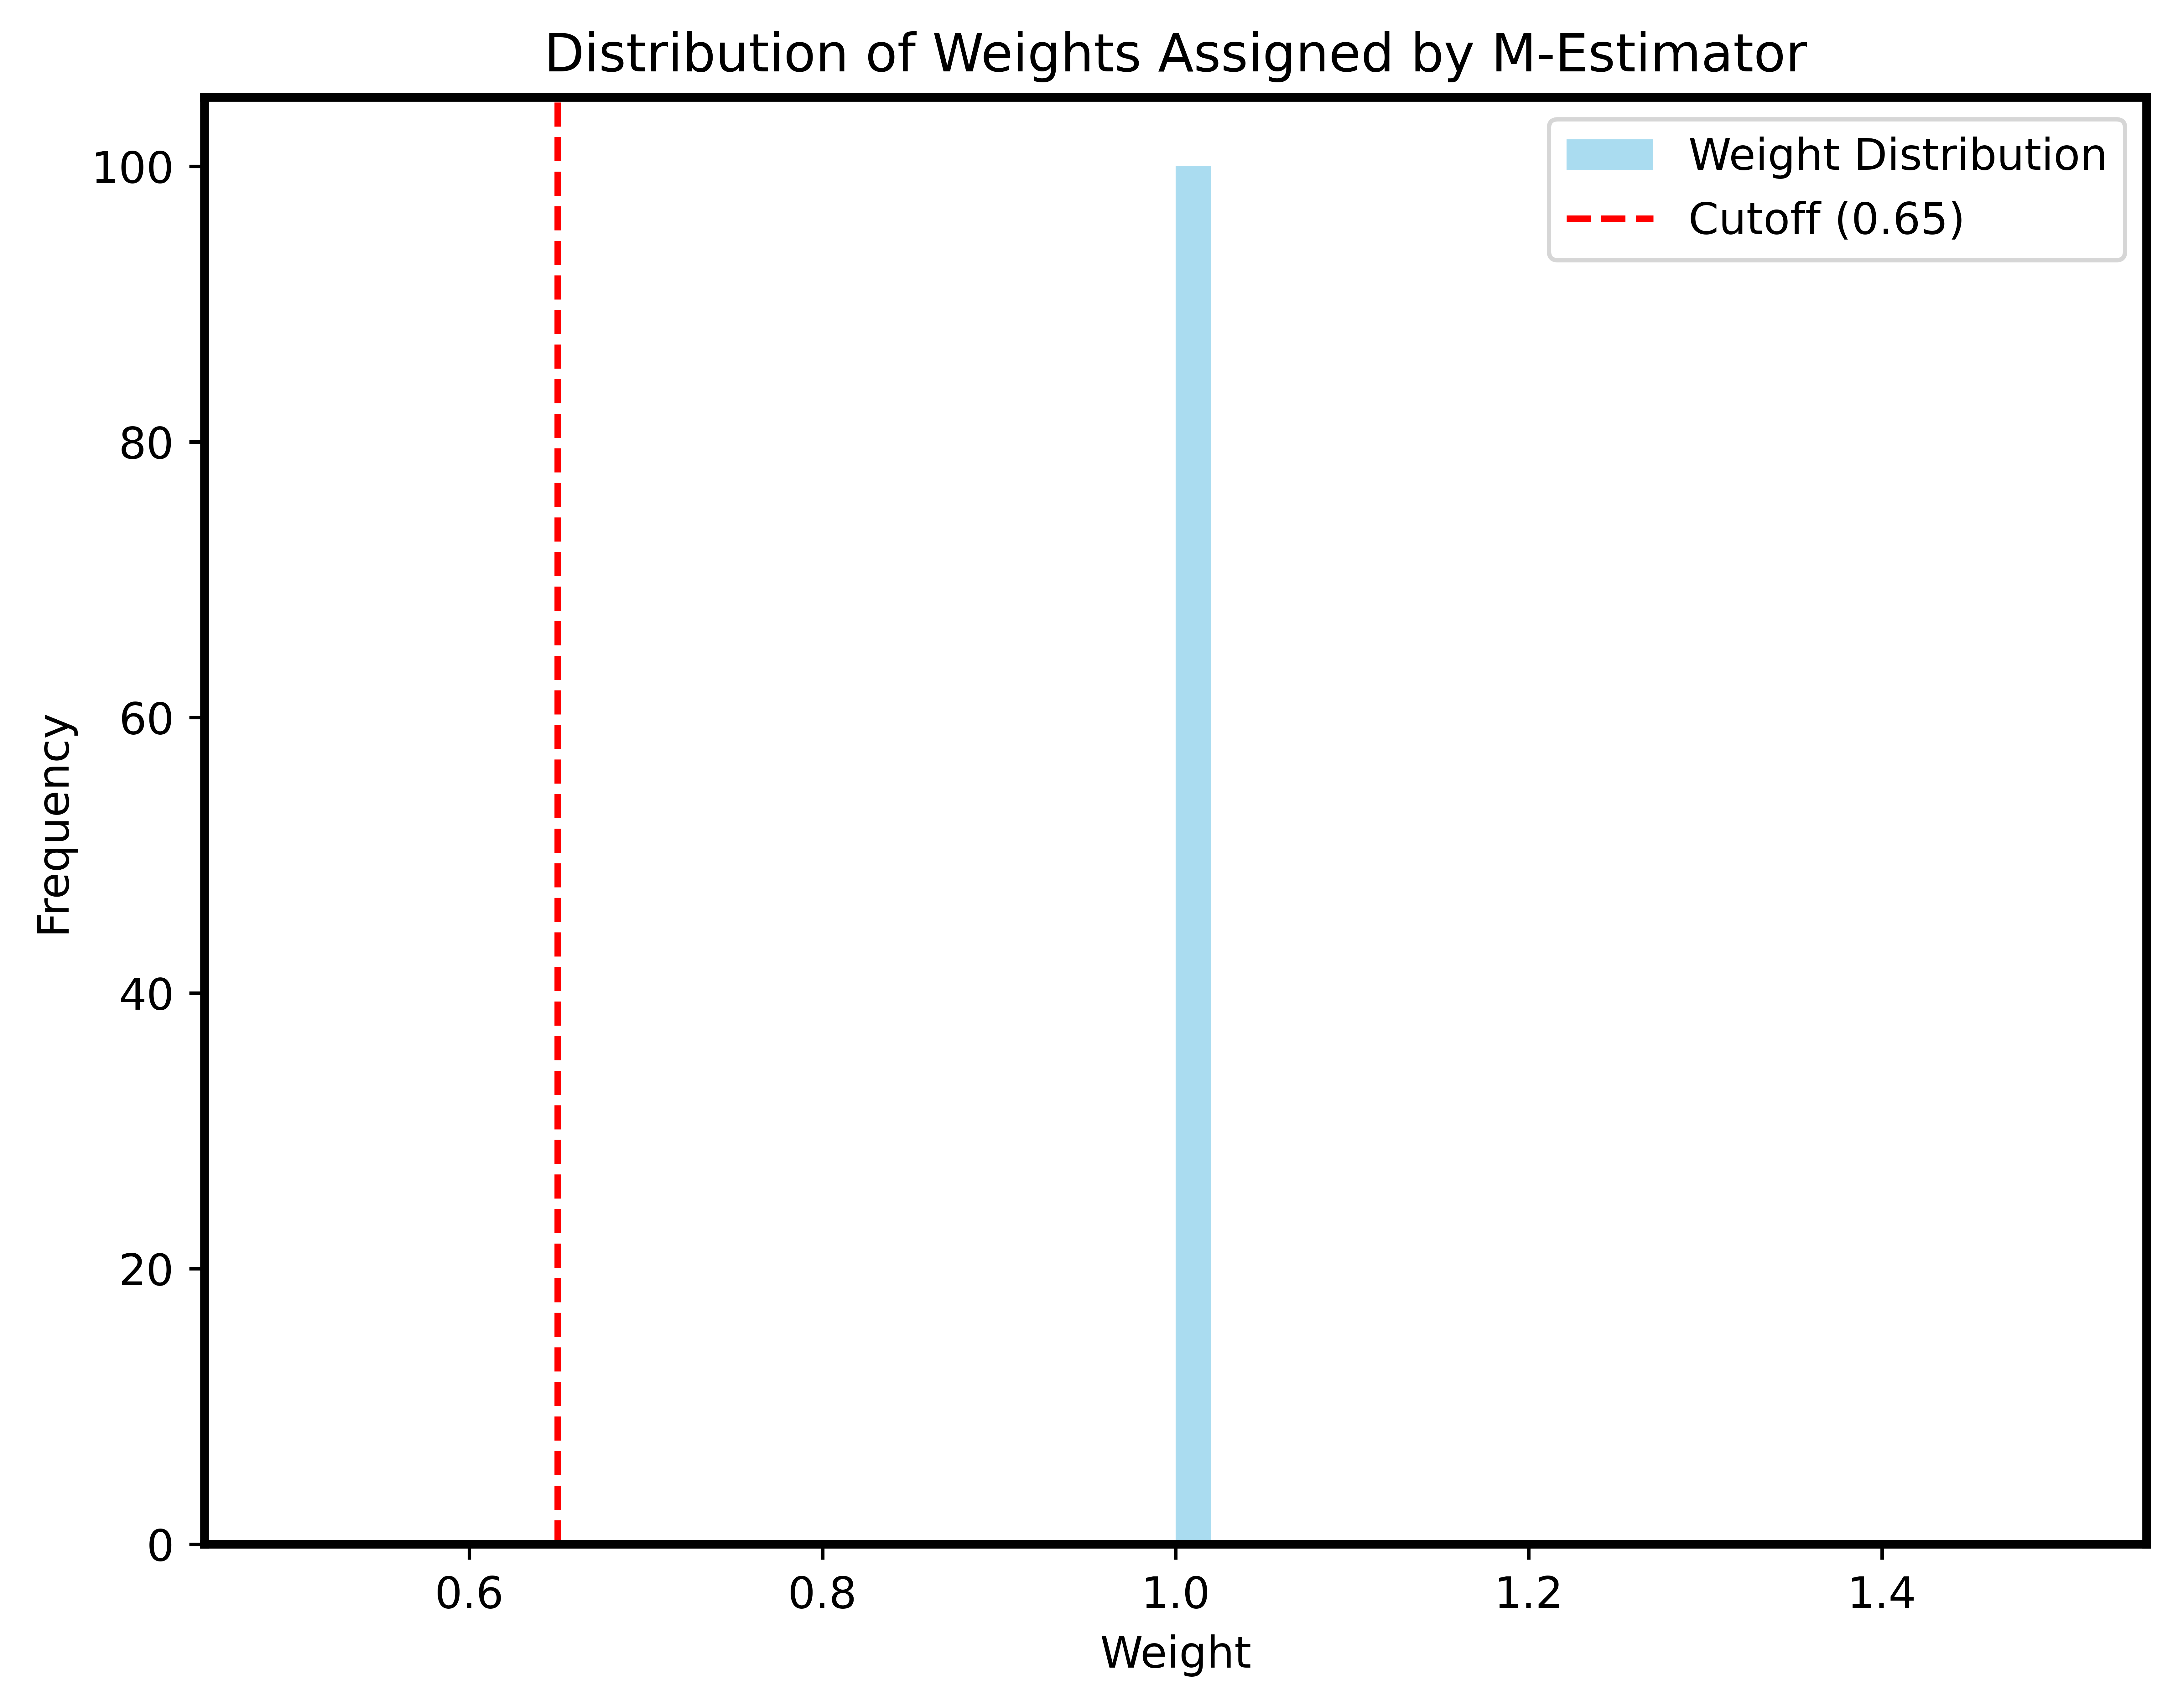

Percentage of data removed: 0.00%
Cleaned dataset saved to 'cleaned_GRB_data_with_weights.csv'.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt

# Load the processed dataset
file_path = "processed_GRB_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Features and target
features = ['log_Ta', 'log_Fa', 'log_PeakFlux', 'log_NH', 'PhotonIndex', 'log_T90']
target = 'log_z+1'

# Drop rows with missing target or features
data = data.dropna(subset=features + [target])

# Prepare feature matrix (X) and target vector (y)
X = data[features].values
y = data[target].values

# Generate polynomial features (quadratic terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Apply HuberRegressor (M-estimator)
huber = HuberRegressor()
huber.fit(X_poly_scaled, y)

# Predict target
y_pred = huber.predict(X_poly_scaled)

# Calculate residuals
residuals = y - y_pred

# Compute weights based on Huber loss
epsilon = huber.epsilon  # Default is 1.35
weights = np.where(
    np.abs(residuals) <= epsilon,
    1,  # Weight = 1 if residuals are within the epsilon threshold
    epsilon / np.abs(residuals)  # Weight decreases for residuals larger than epsilon
)

# Visualize weight distribution
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=50, alpha=0.7, label="Weight Distribution", color="skyblue")
plt.axvline(0.65, color='red', linestyle='--', label="Cutoff (0.65)")
plt.title("Distribution of Weights Assigned by M-Estimator")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Remove outliers based on weight cutoff (< 0.65)
cutoff = 0.65
non_outliers = weights >= cutoff
cleaned_data = data[non_outliers]

# Display the percentage of data removed
removed_percentage = 100 * (1 - len(cleaned_data) / len(data))
print(f"Percentage of data removed: {removed_percentage:.2f}%")

# Save the cleaned dataset
cleaned_data.to_csv("cleaned_GRB_data_with_weights.csv", index=False)
print("Cleaned dataset saved to 'cleaned_GRB_data_with_weights.csv'.")


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt

# Load the processed dataset
file_path = "processed_GRB_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Features and target columns
features = ['log_Ta', 'log_Fa', 'log_PeakFlux', 'log_NH', 'PhotonIndex', 'log_T90']
target = 'log_z+1'

# Check if error columns exist in the dataset
error_columns = ['error_Ta', 'error_Fa', 'error_PeakFlux', 'error_NH', 'error_T90']
existing_error_columns = [col for col in error_columns if col in data.columns]

# If error columns are missing, we only clean based on the available features
if not existing_error_columns:
    print("No error columns found, proceeding without error-based filtering.")

# Drop rows with missing target or feature columns
data = data.dropna(subset=features + [target] + existing_error_columns)

# Prepare feature matrix (X) and target vector (y)
X = data[features].values
y = data[target].values

# Generate polynomial features (quadratic terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Apply HuberRegressor (M-estimator)
huber = HuberRegressor()
huber.fit(X_poly_scaled, y)

# Predict target
y_pred = huber.predict(X_poly_scaled)

# Calculate residuals and weights
residuals = y - y_pred
epsilon = huber.epsilon  # Default is 1.35
weights = np.where(
    np.abs(residuals) <= epsilon,
    1,
    epsilon / np.abs(residuals)
)

# Segregate dataset based on weights
cutoff = 0.65
data['Weight'] = weights
data['Outlier'] = (weights < cutoff).astype(int)  # 1 for outliers, 0 for non-outliers

# Scatter Matrix Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
scatter_matrix = sns.pairplot(
    data,
    vars=features,
    hue='Outlier',
    diag_kind='kde',
    palette={0: "blue", 1: "red"},
    markers=["o", "s"],
    corner=True
)
scatter_matrix.fig.suptitle("Scatter Matrix with Outliers Highlighted", y=1.02)
plt.show()

# Discard Outliers Beyond Error Threshold if error columns are present
if existing_error_columns:
    for feature, error_col in zip(features, existing_error_columns):
        error_ratio = data[error_col] / data[feature].abs()
        data = data[error_ratio <= 1]  # Keep rows where ∆x/x <= 1

# Display Final Dataset Size
final_percentage = 100 * len(data) / len(pd.read_csv(file_path))
print(f"Final dataset retains {final_percentage:.2f}% of the original data.")

# Save the Cleaned Dataset
data.to_csv("final_cleaned_GRB_data.csv", index=False)
print("Final cleaned dataset saved to 'final_cleaned_GRB_data.csv'.")


No error columns found, proceeding without error-based filtering.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/

<Figure size 10000x8000 with 0 Axes>

Final dataset retains 100.00% of the original data.
Final cleaned dataset saved to 'final_cleaned_GRB_data.csv'.
